### 1.导库，获取数据

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR

In [6]:
data = pd.read_csv('rankingcard.csv', index_col=0)

### 2.探索数据和数据预处理

#### 2.1.数据基本信息

In [7]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
data.shape

(150000, 11)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

#### 2.2.数据集各个特征的含义

| 特征/标签                            | 含义                                              |
| ------------------------------------ | ------------------------------------------------- |
| SeriousDlqin2yrs                     | 出现 90 天或更长时间的逾期行为（即定义好坏客户）  |
| RevolvingUtilizationOfUnsecuredLines | 贷款以及信用卡可用额度与总额度比例                |
| age                                  | 借款人借款年龄                                    |
| NumberOfTime30-59DaysPastDueNotWorse | 过去两年内出现35-59天逾期但是没有发展得更坏的次数 |
| DebtRatio                            | 每月偿还债务，赡养费，生活费用除以月总收入        |
| MonthlyIncome                        | 月收入                                            |
| NumberOfOpenCreditLinesAndLoans      | 开放式贷款和信贷数量                              |
| NumberOfTimes90DaysLate              | 过去两年内出现90天逾期或更坏的次数                |
| NumberRealEstateLoansOrLines         | 抵押贷款和房地产贷款数量，包括房屋净值信贷额度    |
| NumberOfTime60-89DaysPastDueNotWorse | 过去两年内出现60-89天逾期但是没有发展得更坏的次数 |
| NumberOfDependents                   | 家庭中不包括自身的家属人数（配偶，子女等）        |

#### 2.3.去除重复值

In [10]:
data.drop_duplicates(inplace=True)
data.index = range(data.shape[0])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

#### 2.4.填补缺失值

In [12]:
data.isnull().sum()/data.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [13]:
# 家属人数这一列用均值填充
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()),inplace=True)  

In [14]:
# 收入用随机森林填充
def fill_missing_rf(X,y,to_fill):
    """
   使用随机森林填补一个特征的缺失值的函数
   参数：
   X：要填补的特征矩阵
   y：完整的，没有缺失值的标签
   to_fill：字符串，要填补的那一列的名称
   """
    #构建我们的新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)
    #找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)
    return Ypredict

In [15]:
X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]
y_pred = fill_missing_rf(X,y,"MonthlyIncome")
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

In [16]:
data.isnull().sum()/data.shape[0]

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

#### 2.5.描述性统计异常值

In [17]:
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5425.200107,13237.111835,0.0,0.0,0.180000,1800.000000,4418.000000,7416.000000,10800.000000,23250.600000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [18]:
# 删除年龄为0的数据
(data["age"] == 0).sum()

1

In [19]:
data = data[data["age"] != 0]

In [20]:
data[data.loc[:,"NumberOfTimes90DaysLate"] > 90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [21]:
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]

In [22]:
data.index = range(data.shape[0])

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

#### 2.6.样本不均衡问题

In [24]:
#探索标签的分布
X = data.iloc[:,1:]
y = data.iloc[:,0]
y.value_counts()
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]
print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))

样本个数：149165; 1占6.62%; 0占93.38%


In [25]:
import imblearn
#imblearn是专门用来处理不平衡数据集的库，在处理样本不均衡问题中性能高过sklearn很多
#imblearn里面也是一个个的类，也需要进行实例化，fit拟合，和sklearn用法相似
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42) #实例化
X,y = sm.fit_resample(X,y)
n_sample_ = X.shape[0]
pd.Series(y).value_counts()
n_1_sample = pd.Series(y).value_counts()[1]
n_0_sample = pd.Series(y).value_counts()[0]
print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample_,n_1_sample/n_sample_,n_0_sample/n_sample_))

样本个数：278584; 1占50.00%; 0占50.00%


#### 2.7拆分训练集和测试集

In [26]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X_train, X_vali, Y_train, Y_vali = train_test_split(X,y,test_size=0.3,random_state=420)
model_data = pd.concat([Y_train, X_train], axis=1)
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns
vali_data = pd.concat([Y_vali, X_vali], axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns
model_data.to_csv("model_data.csv")
vali_data.to_csv("vali_data.csv")

### 3.分箱

#### 3.1.以age为例进行分箱，按照等频对需要分箱的列进行分箱

In [27]:
model_data["qcut"], updown = pd.qcut(model_data["age"], retbins=True, q=20)
"""
pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化
只能够处理一维数据。返回箱子的上限和下限
参数q：要分箱的个数
参数retbins=True来要求同时返回结构为索引为样本索引，元素为分到的箱子的Series
现在返回两个值：每个样本属于哪个箱子，以及所有箱子的上限和下限
"""

'\npd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化\n只能够处理一维数据。返回箱子的上限和下限\n参数q：要分箱的个数\n参数retbins=True来要求同时返回结构为索引为样本索引，元素为分到的箱子的Series\n现在返回两个值：每个样本属于哪个箱子，以及所有箱子的上限和下限\n'

#### 3.2.统计每个分箱中0和1的数量

In [28]:
# 这里使用了数据透视表的功能groupby
coount_y0 = model_data[model_data["SeriousDlqin2yrs"] == 0].groupby(by="qcut").count()["SeriousDlqin2yrs"]
coount_y1 = model_data[model_data["SeriousDlqin2yrs"] == 1].groupby(by="qcut").count()["SeriousDlqin2yrs"]
#num_bins值分别为每个区间的上界，下界，0出现的次数，1出现的次数
num_bins = [*zip(updown, updown[1:], coount_y0, coount_y1)]
#注意zip会按照最短列来进行结合
num_bins

[(21.0, 28.0, 4243, 7540),
 (28.0, 31.0, 3571, 5893),
 (31.0, 34.0, 4075, 6777),
 (34.0, 36.0, 2908, 4630),
 (36.0, 39.0, 5182, 7452),
 (39.0, 41.0, 3956, 5845),
 (41.0, 43.0, 4002, 5672),
 (43.0, 45.0, 4389, 5991),
 (45.0, 46.0, 2419, 3286),
 (46.0, 48.0, 4813, 6167),
 (48.0, 50.0, 4900, 6175),
 (50.0, 52.0, 4728, 5806),
 (52.0, 54.0, 4681, 5054),
 (54.0, 56.0, 4677, 4028),
 (56.0, 58.0, 4483, 3413),
 (58.0, 61.0, 6583, 4787),
 (61.0, 64.0, 6968, 3226),
 (64.0, 68.0, 6623, 2293),
 (68.0, 74.0, 6753, 1913),
 (74.0, 107.0, 7737, 1369)]

#### 3.3.确保每个箱子里都有0和1

#### 3.4.定义WOE和IV函数

#### 3.5.卡方检验，合并箱体，画出IV曲线

In [29]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    """
   自动最优分箱函数，基于卡方检验的分箱
   参数：
   DF: 需要输入的数据
   X: 需要分箱的列名
   Y: 分箱数据对应的标签 Y 列名
   n: 保留分箱个数
   q: 初始分箱的个数
   graph: 是否要画出IV图像
   区间为前开后闭 (]
   """    
    
    DF = DF[[X,Y]].copy()
    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
               num_bins[0][3]+num_bins[1][3])]
            continue
            
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break
    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df
    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv
    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)
        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
    if graph:    
        plt.figure()
        plt.plot(axisx,IV) 
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show() 
    return bins_df                

#### 3.6. 对所有特征进行分箱选择

In [30]:
model_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'qcut'],
      dtype='object')

In [31]:
# 能使用自动分箱的变量
auto_col_bins = ["RevolvingUtilizationOfUnsecuredLines",
                 "age",
                 "DebtRatio",
                 "MonthlyIncome",
                 "NumberOfOpenCreditLinesAndLoans"]

RevolvingUtilizationOfUnsecuredLines


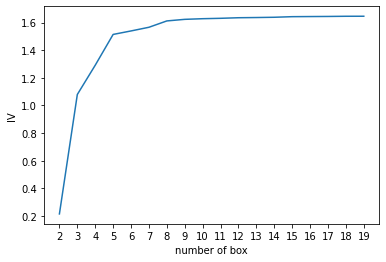

age


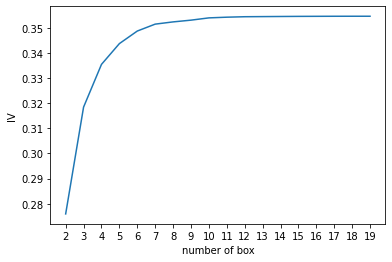

DebtRatio


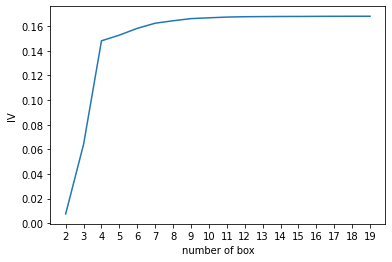

MonthlyIncome


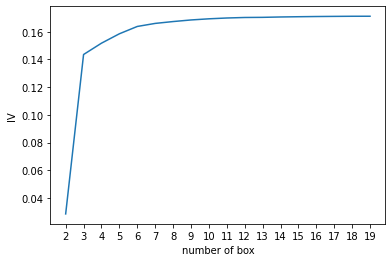

NumberOfOpenCreditLinesAndLoans


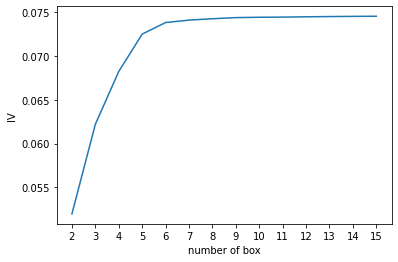

In [32]:
import scipy
from matplotlib import pyplot as plt
for i in auto_col_bins:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)

In [33]:
#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
             ,"NumberOfTimes90DaysLate":[0,1,2,17]
             ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
             ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
             ,"NumberOfDependents":[0,1,2,3]}

#保证区间覆盖使用 np.inf替换最大值，用-np.inf替换最小值
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [34]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [35]:
# 接下来对所有特征按照选择的箱体个数和手写的分箱范围进行分箱

In [36]:
# 选择每个特征合适的分箱个数
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
                 "age":5,
                 "DebtRatio":4,
                 "MonthlyIncome":3,
                 "NumberOfOpenCreditLinesAndLoans":5}
bins_of_col = {}
# 生成自动分箱的分箱区间和分箱后的 IV 值
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data, col, "SeriousDlqin2yrs", n=auto_col_bins[col], q=20, graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
#合并手动分箱数据    
bins_of_col.update(hand_bins)

In [37]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.099056963,
  0.29790676517729403,
  0.46542908570269403,
  0.9825704227078549,
  0.9999999,
  inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.017433677062800444,
  0.4018586764247716,
  1.4748297483027208,
  inf],
 'MonthlyIncome': [-inf, 0.1, 5600.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

### 3.7 计算各箱的WOE并映射到数据中

In [38]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe
#将所有特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0991]     2.201896
 (0.0991, 0.298]    0.669123
 (0.298, 0.465]    -0.125312
 (0.465, 0.983]    -1.074357
 (0.983, 1.0]      -0.478374
 (1.0, inf]        -2.035324
 dtype: float64,
 'age': cut
 (-inf, 36.0]   -0.521867
 (36.0, 54.0]   -0.279052
 (54.0, 61.0]    0.248832
 (61.0, 74.0]    1.003155
 (74.0, inf]     1.728098
 dtype: float64,
 'DebtRatio': cut
 (-inf, 0.0174]     1.511942
 (0.0174, 0.402]    0.037354
 (0.402, 1.475]    -0.389596
 (1.475, inf]       0.174782
 dtype: float64,
 'MonthlyIncome': cut
 (-inf, 0.1]      1.453964
 (0.1, 5600.0]   -0.238273
 (5600.0, inf]    0.231886
 dtype: float64,
 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.849364
 (1.0, 3.0]    -0.333280
 (3.0, 5.0]    -0.054676
 (5.0, 17.0]    0.125034
 (17.0, inf]    0.463135
 dtype: float64,
 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.353692
 (0.0, 1.0]    -0.875658
 (1.0, 2.0]    -1.379771
 (2.0, inf]    -1.537690
 dtype:

In [39]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)
#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])
#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
#这就是我们的建模数据了
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.279052,2.201896,0.037354,-0.238273,-0.054676,0.353692,0.236333,-0.393101,0.123391,0.625007,0
1,1.003155,0.669123,0.037354,-0.238273,-0.054676,0.353692,0.236333,-0.393101,0.123391,0.625007,0
2,-0.279052,-2.035324,-0.389596,-0.238273,-0.054676,-0.875658,-1.758108,-0.393101,-1.766925,-0.477441,1
3,1.003155,2.201896,-0.389596,-0.238273,0.125034,0.353692,0.236333,0.617950,0.123391,0.625007,0
4,-0.279052,-1.074357,-0.389596,0.231886,0.125034,0.353692,0.236333,0.617950,0.123391,-0.580132,1


In [40]:
model_woe.columns.tolist()

['age',
 'RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'SeriousDlqin2yrs']

In [41]:
#处理测试集
vali_woe = pd.DataFrame(index=vali_data.index)
for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]



### 3.8 建模与模型验证

In [42]:
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
from sklearn.linear_model import LogisticRegression as LR
lr = LR().fit(X,y)
lr.score(vali_X, vali_y)

D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.7756054369675505

In [43]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

In [44]:
# 通过调整C和max_iter的学习曲线把逻辑回归的效果调上去

D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages

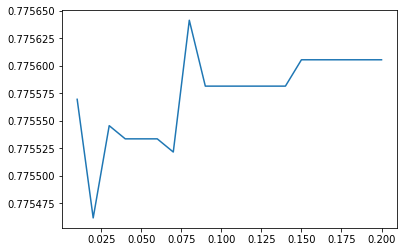

D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\svm\_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\svm\_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(messag

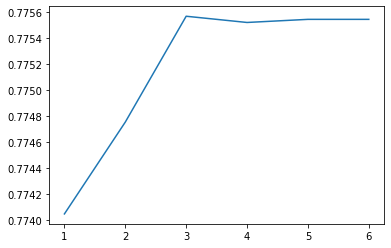

In [45]:
score = []
for i in c_2: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_2,score)
plt.show()
lr.n_iter_
score = []
for i in [1,2,3,4,5,6]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6],score)
plt.show()

In [46]:
# 绘制ROC曲线

D:\WorkSoftware\Miniconda3\envs\trial_image\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

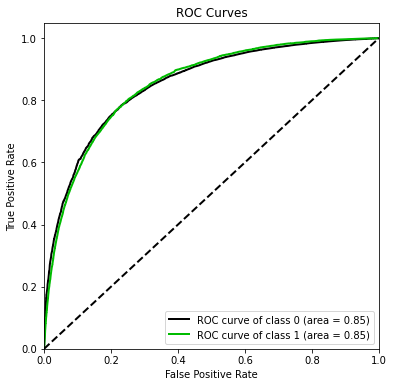

In [47]:
import scikitplot as skplt
vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df,
                       plot_micro=False,figsize=(6,6),
                       plot_macro=False)

### 3.9 制作评分卡

In [48]:
'''A叫做“补偿”，B叫做“刻度”。两个常数可以通过两个假设的分值带入公式求出，这两个假设分别是：
1. 某个特定的违约概率下的预期分值
2. 指定的违约概率翻倍的分数（PDO）
例如，假设对数几率为 时设定的特定分数为600，PDO=20，那么对数几率为 时的分数就是620。带入以上线
性表达式，可以得到：
'''

'A叫做“补偿”，B叫做“刻度”。两个常数可以通过两个假设的分值带入公式求出，这两个假设分别是：\n1. 某个特定的违约概率下的预期分值\n2. 指定的违约概率翻倍的分数（PDO）\n例如，假设对数几率为 时设定的特定分数为600，PDO=20，那么对数几率为 时的分数就是620。带入以上线\n性表达式，可以得到：\n'

In [49]:
B = -20/np.log(2)
A = 600 + B*np.log(1/60)
B,A

(-28.85390081777927, 718.1378119121704)

In [50]:
base_score = A - B*lr.intercept_
base_score

array([717.99713159])

In [51]:
lr.coef_

array([[-0.27674224, -0.75014418, -0.75221699, -0.50495286, -0.29315199,
        -0.54471886, -0.56753973, -0.924126  , -0.27501274, -0.80528028]])

In [52]:
woeall['age']

cut
(-inf, 36.0]   -0.521867
(36.0, 54.0]   -0.279052
(54.0, 61.0]    0.248832
(61.0, 74.0]    1.003155
(74.0, inf]     1.728098
dtype: float64

In [53]:
score_age = woeall["age"] * (-B*lr.coef_[0][0])
score_age

cut
(-inf, 36.0]     4.167153
(36.0, 54.0]     2.228260
(54.0, 61.0]    -1.986944
(61.0, 74.0]    -8.010288
(74.0, inf]    -13.799021
dtype: float64

In [54]:
file = "ScoreData.csv"
#open是用来打开文件的python命令，第一个参数是文件的路径+文件名，如果你的文件是放在根目录下，则你只需要文件名就好
#第二个参数是打开文件后的用途，"w"表示用于写入，通常使用的是"r"，表示打开来阅读
#首先写入基准分数
#之后使用循环，每次生成一组score_age类似的分档和分数，不断写入文件之中
with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")